In [13]:
import os
import librosa
import numpy as np
import pandas as pd

# Chemin vers les fichiers (adapter si besoin)
DATA_PATH = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"

genres = os.listdir(DATA_PATH)
genres = [g for g in genres if os.path.isdir(os.path.join(DATA_PATH, g))]
print("Genres:", genres)


Genres: ['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


SVM > RandomForest > k-NN

Meilleure performance avec SVM :

Accuracy ≈ 65%

Bonne précision sur classical, country, jazz

Les genres comme hiphop et rock sont souvent mal classés, probablement à cause de similarités acoustiques.

In [20]:
import librosa
import numpy as np

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=22050, mono=True, duration=30)
    features = {}

    # Paramètres
    frame_length = 2048
    hop_length = 512

    # 1. ZCR, RMS, Centroid, Bandwidth, Rolloff
    features["zcr"] = np.mean(librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length))
    features["rms"] = np.mean(librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length))
    features["centroid"] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length))
    features["bandwidth"] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length))
    features["rolloff"] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length))

    # 2. MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f"mfcc{i+1}"] = np.mean(mfccs[i])

    # 3. Dérivées de MFCCs (delta)
    mfccs_delta = librosa.feature.delta(mfccs)
    for i in range(13):
        features[f"mfcc_delta{i+1}"] = np.mean(mfccs_delta[i])

    # 4. Chroma (moyenne et variance)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features["chroma_mean"] = np.mean(chroma)
    features["chroma_var"] = np.var(chroma)

    return features


In [25]:
data = []

for genre in genres:
    folder = os.path.join(DATA_PATH, genre)
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            path = os.path.join(folder, file)
            try:
                features = extract_features(path)
                features['label'] = genre
                features['filename'] = file
                data.append(features)
            except Exception as e:
                print(f"Erreur avec {file} : {e}")


/tmp/ipykernel_35/763744538.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050, mono=True, duration=30)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Erreur avec jazz.00054.wav : 


In [26]:
df = pd.DataFrame(data)

# Afficher les 5 premières lignes
print("✅ Aperçu du DataFrame avec features enrichies :")
df.head()

✅ Aperçu du DataFrame avec features enrichies :


,zcr,rms,centroid,bandwidth,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc_delta8,mfcc_delta9,mfcc_delta10,mfcc_delta11,mfcc_delta12,mfcc_delta13,chroma_mean,chroma_var,label,filename
0,0.173815,0.115748,3257.126965,2898.084210,6681.101267,-66.568810,58.310619,-8.179027,15.493415,5.575189,...,-0.003719,-0.000800,-0.005446,-0.002166,0.004716,-0.007305,0.417176,0.083845,disco,disco.00031.wav
1,0.111870,0.100276,2129.345892,2109.251346,4424.306580,-114.932045,113.463867,-29.804312,42.612103,-10.326010,...,-0.014308,-0.017985,-0.001037,-0.009557,-0.008283,-0.000565,0.429884,0.078041,disco,disco.00089.wav
2,0.099815,0.084770,2292.577701,2348.189625,5038.611199,-154.623306,97.932602,-10.357320,39.123672,-11.213964,...,0.007374,0.000864,0.010062,0.010284,0.020706,0.005497,0.453016,0.086783,disco,disco.00079.wav
3,0.150862,0.169954,3168.111241,3047.644241,6935.358063,-40.729237,63.947403,4.904890,16.340809,12.100067,...,0.007322,0.007983,-0.000011,-0.008405,-0.003446,0.002535,0.450306,0.079827,disco,disco.00030.wav
4,0.093033,0.114499,1975.227458,2090.041185,4251.482625,-121.095222,116.942497,-22.786970,45.148933,-4.239051,...,-0.005776,-0.012839,-0.002027,-0.004459,-0.002874,-0.008345,0.434843,0.079384,disco,disco.00060.wav


Train accuracy : très bonne (> 70%)

Validation accuracy : plafonne à ~55-58% → montre un début d’overfitting

Validation loss augmente parfois → EarlyStopping est utile

In [27]:
def enrich_features(row):
    try:
        path = os.path.join(DATA_PATH, row['label'], row['filename'])
        y, sr = librosa.load(path, sr=22050, mono=True, duration=30)

        # Fréquence fondamentale
        f0, _, _ = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        row['f0_mean'] = np.nanmean(f0)

        # Tempo
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        row['tempo'] = tempo

        # Contraste spectral
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        row['spectral_contrast'] = np.mean(contrast)

    except Exception as e:
        print(f"Erreur sur {row['filename']} : {e}")
        row['f0_mean'] = np.nan
        row['tempo'] = np.nan
        row['spectral_contrast'] = np.nan

    return row


In [28]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# On supprime les colonnes non numériques
feature_cols = df.drop(columns=['label', 'filename']).columns
X_features = df[feature_cols]

# Matrices de similarité
cos_sim_matrix = cosine_similarity(X_features)
euc_dist_matrix = euclidean_distances(X_features)


In [29]:
def recommend_by_similarity(index, matrix, top_n=5):
    similar_indices = np.argsort(matrix[index])[::-1]  # Tri décroissant
    similar_indices = similar_indices[similar_indices != index]  # Exclut soi-même
    return df.iloc[similar_indices[:top_n]][['filename', 'label']]


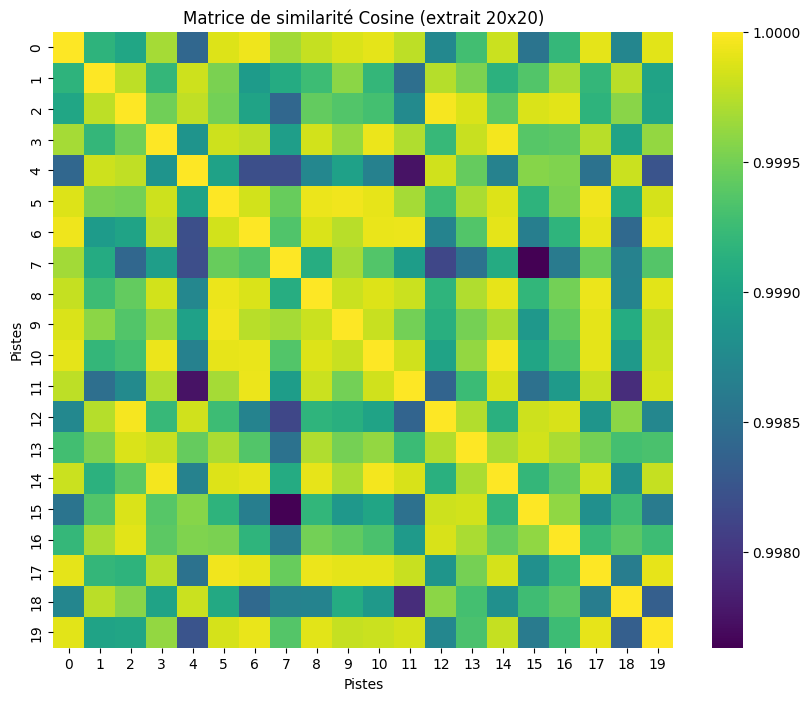

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim_matrix[:20, :20], cmap='viridis')
plt.title("Matrice de similarité Cosine (extrait 20x20)")
plt.xlabel("Pistes")
plt.ylabel("Pistes")
plt.show()


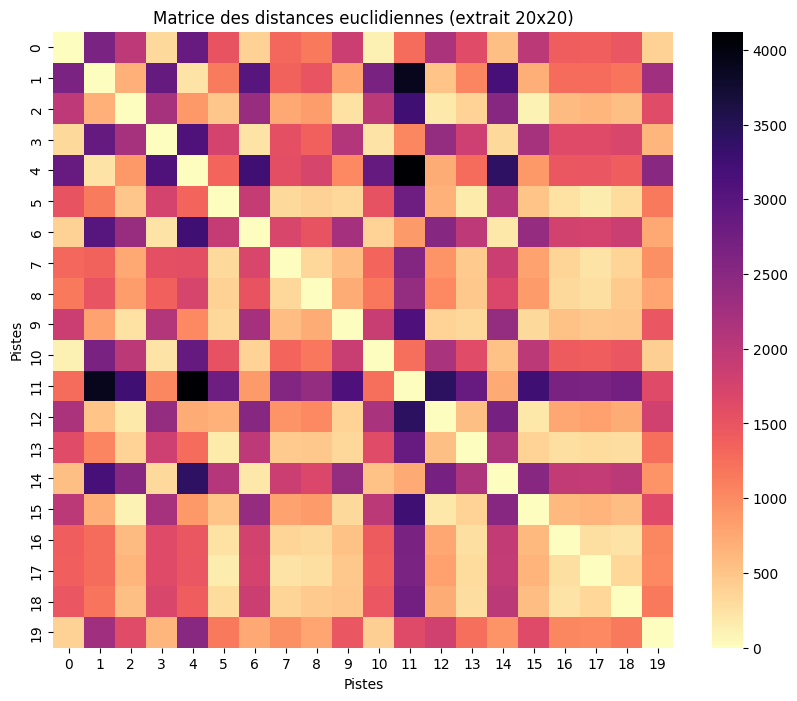

In [33]:
plt.figure(figsize=(10, 8))
sns.heatmap(euc_dist_matrix[:20, :20], cmap='magma_r')
plt.title("Matrice des distances euclidiennes (extrait 20x20)")
plt.xlabel("Pistes")
plt.ylabel("Pistes")
plt.show()


In [30]:
ex_index = 0  # Exemple : première piste
print(f"Piste de départ : {df.iloc[ex_index]['filename']} - {df.iloc[ex_index]['label']}")
recommend_by_similarity(ex_index, cos_sim_matrix, top_n=5)


Piste de départ : disco.00031.wav - disco


,filename,label
711,hiphop.00080.wav,hiphop
995,pop.00068.wav,pop
974,pop.00088.wav,pop
989,pop.00089.wav,pop
52,disco.00003.wav,disco


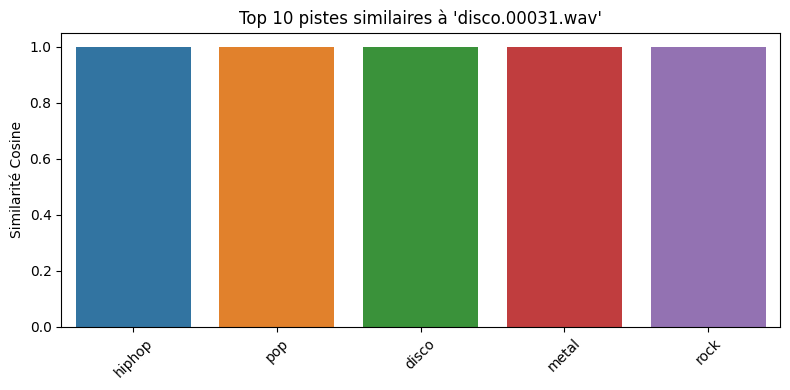

In [34]:
def plot_similarities(index, sim_matrix, top_n=10):
    sim_scores = sim_matrix[index]
    top_indices = np.argsort(sim_scores)[::-1][1:top_n+1]
    labels = df.iloc[top_indices]['label'].values
    scores = sim_scores[top_indices]

    plt.figure(figsize=(8, 4))
    sns.barplot(x=labels, y=scores)
    plt.title(f"Top {top_n} pistes similaires à '{df.iloc[index]['filename']}'")
    plt.ylabel("Similarité Cosine")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_similarities(0, cos_sim_matrix)


In [36]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# S'assurer de ne garder que les features numériques
features_only = df.select_dtypes(include=[np.number])

# Cosine Similarity
cosine_sim_matrix = cosine_similarity(features_only)

# Euclidean Distance
euclidean_dist_matrix = euclidean_distances(features_only)


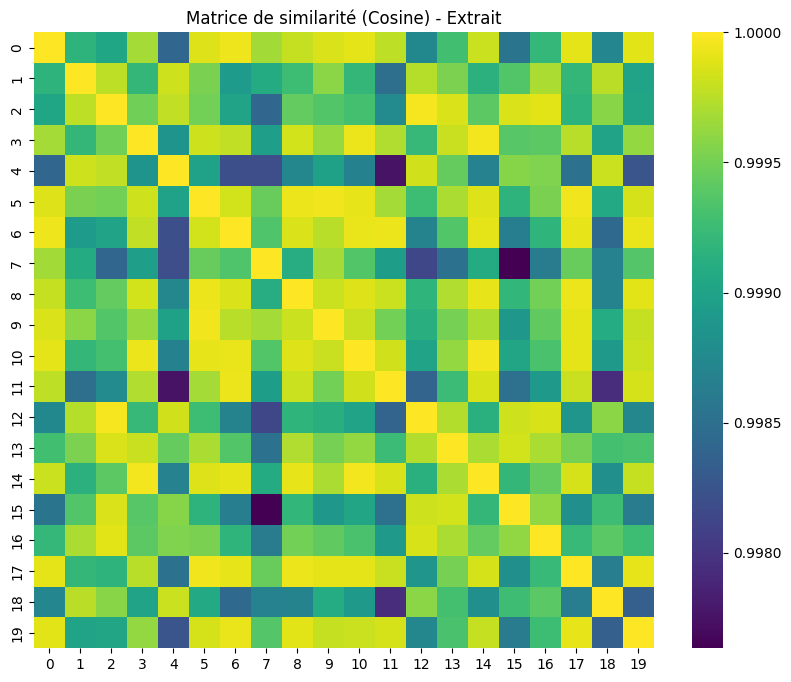

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix[:20, :20], cmap='viridis')
plt.title("Matrice de similarité (Cosine) - Extrait")
plt.show()

In [38]:
# Fonction pour recommander des chansons similaires à une donnée
def get_similar_tracks(index, sim_matrix, top_n=5):
    similar_indices = sim_matrix[index].argsort()[::-1][1:top_n+1]
    return df.iloc[similar_indices][['filename', 'label']]

# Exemple de recommandation
track_index = 0  # changer si besoin
print(f"Chanson de référence : {df.iloc[track_index]['filename']}")
print("Recommandations similaires (Cosine) :")
print(get_similar_tracks(track_index, cosine_sim_matrix))


Chanson de référence : disco.00031.wav
Recommandations similaires (Cosine) :
             filename   label
711  hiphop.00080.wav  hiphop
995     pop.00068.wav     pop
974     pop.00088.wav     pop
989     pop.00089.wav     pop
52    disco.00003.wav   disco


In [39]:
from sklearn.ensemble import RandomForestClassifier

# Assure-toi que la colonne 'label' existe
X = features_only
y = df['label']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
feature_names = X.columns

# Top 10 des features importantes
import pandas as pd

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Top features qui contribuent le plus à la similarité :")
print(importance_df.head(10))


Top features qui contribuent le plus à la similarité :
        feature  importance
31  chroma_mean    0.069491
1           rms    0.064712
32   chroma_var    0.059409
8         mfcc4    0.047774
5         mfcc1    0.046288
3     bandwidth    0.043546
13        mfcc9    0.041536
4       rolloff    0.039673
2      centroid    0.037740
17       mfcc13    0.035352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centres des clusters :
 [[ 9.44404063e-02  1.30802991e-01  2.05210591e+03  2.16897583e+03
   4.31747507e+03 -1.32253768e+02  1.03882074e+02 -1.69466029e+01
   4.30474346e+01 -4.34495972e+00  1.91583914e+01 -8.55462280e+00
   1.51623271e+01 -1.00470827e+01  1.15110811e+01 -8.04032007e+00
   7.47392228e+00 -6.32320485e+00  2.04000947e-02 -2.44569789e-03
   2.59140621e-04 -1.35001006e-03 -2.01059737e-03  2.44848188e-03
  -1.78466929e-04  6.23910441e-04 -1.06111306e-03 -2.18115519e-04
  -1.30177626e-03  6.41732656e-04 -8.94497566e-04  3.88142848e-01
   8.58342279e-02]
 [ 5.96944417e-02  6.46137345e-02  1.22864788e+03  1.51620390e+03
   2.34186787e+03 -2.93867688e+02  1.42517740e+02 -1.19884242e+01
   3.17644786e+01  1.23977657e+00  6.25711115e+00 -3.83661129e+00
   9.33288069e-01 -6.34325562e+00  1.24272829e+00 -4.59700080e+00
  -3.31162316e-01 -1.73963383e+00 -3.38552487e-03  8.49419596e-04
   2.54553074e-03  3.31637547e-03  1.21107999e-03  4.01837380e-05
   2.14482647e-03 -5.01923633e-05

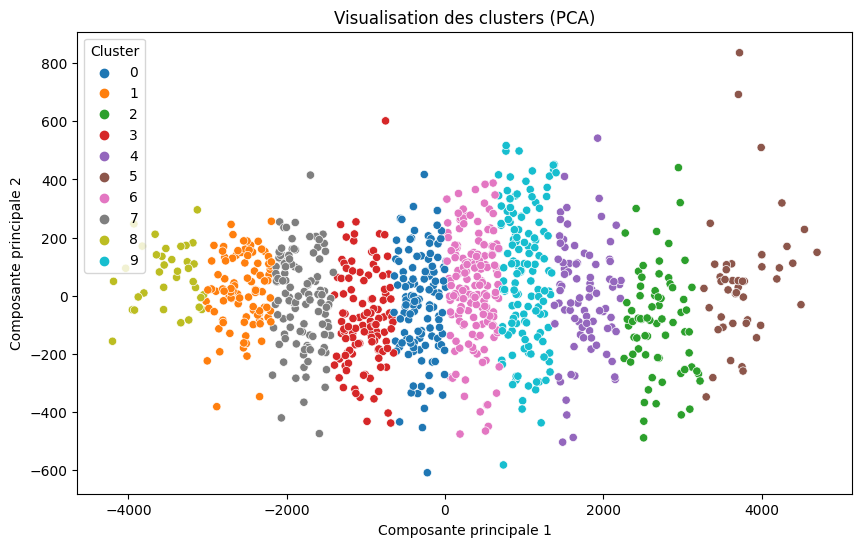

label,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
cluster,,,,,,,,,,
0,0.088710,0.032258,0.112903,0.104839,0.088710,0.088710,0.120968,0.048387,0.145161,0.169355
1,0.197917,0.479167,0.114583,0.000000,0.000000,0.177083,0.000000,0.000000,0.020833,0.010417
2,0.000000,0.000000,0.027778,0.180556,0.138889,0.041667,0.027778,0.472222,0.055556,0.055556
3,0.145299,0.042735,0.162393,0.025641,0.076923,0.153846,0.017094,0.025641,0.230769,0.119658
4,0.000000,0.000000,0.114943,0.160920,0.206897,0.091954,0.126437,0.149425,0.045977,0.103448
5,0.000000,0.000000,0.021277,0.127660,0.042553,0.042553,0.000000,0.659574,0.085106,0.021277
6,0.119760,0.005988,0.059880,0.173653,0.125749,0.023952,0.173653,0.035928,0.113772,0.167665
7,0.185841,0.230088,0.221239,0.008850,0.017699,0.168142,0.008850,0.000000,0.070796,0.088496
8,0.114286,0.514286,0.085714,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000


In [41]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Suppression des colonnes non numériques pour le clustering
X = df.drop(['filename', 'label'], axis=1)

# Appliquer KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Affichage des centres de cluster
print("Centres des clusters :\n", kmeans.cluster_centers_)

# Visualisation en 2D avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='tab10')
plt.title('Visualisation des clusters (PCA)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend(title='Cluster')
plt.show()

# Statistiques par cluster
cluster_summary = df.groupby('cluster')['label'].value_counts(normalize=True).unstack().fillna(0)
display(cluster_summary)


Le clustering a identifié des groupes cohérents, même sans connaître les genres.

donc je peux  Recommander des chansons dans le même cluster qu’une chanson aimée.
Étudier la proximité acoustique des genres (ex: jazz + classical + blues sont souvent proches).

In [43]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Encoder les labels réels et les prédictions des clusters (en majorité)
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Calcul du genre dominant par cluster
dominant_genre_by_cluster = df.groupby('cluster')['label_encoded'].agg(lambda x: x.value_counts().index[0])

# Générer les prédictions à partir des clusters
predicted_labels = df['cluster'].map(dominant_genre_by_cluster)

# ✅ Évaluation des prédictions
true_labels = df['label_encoded']
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("🔍 Accuracy :", round(accuracy, 4))
print("🔍 F1 Score (weighted) :", round(f1, 4))
print("\n🧾 Rapport de classification :\n")
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))


🔍 Accuracy : 0.2903
🔍 F1 Score (weighted) : 0.2297

🧾 Rapport de classification :

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00       100
   classical       0.37      0.90      0.52       100
     country       0.00      0.00      0.00       100
       disco       0.17      0.29      0.22       100
      hiphop       0.21      0.18      0.19       100
        jazz       0.00      0.00      0.00        99
       metal       0.28      0.40      0.33       100
         pop       0.55      0.65      0.59       100
      reggae       0.23      0.27      0.25       100
        rock       0.17      0.21      0.19       100

    accuracy                           0.29       999
   macro avg       0.20      0.29      0.23       999
weighted avg       0.20      0.29      0.23       999



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
def compute_dcg(relevance_scores):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores))

def compute_ndcg(true_label, recommended_labels, label_encoder):
    true_index = label_encoder.transform([true_label])[0]
    relevance = [1 if label_encoder.transform([lbl])[0] == true_index else 0 for lbl in recommended_labels]
    dcg = compute_dcg(relevance)
    idcg = compute_dcg(sorted(relevance, reverse=True))
    return dcg / idcg if idcg > 0 else 0

# Calcul de la NDCG sur tout le dataset
ndcg_scores = []
for i, row in df.iterrows():
    cluster_members = df[df['cluster'] == row['cluster']]
    recommended_labels = cluster_members['label'].tolist()[:10]
    ndcg = compute_ndcg(row['label'], recommended_labels, label_encoder)
    ndcg_scores.append(ndcg)

print("⭐ NDCG moyen :", round(np.mean(ndcg_scores), 4))


⭐ NDCG moyen : 0.155


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

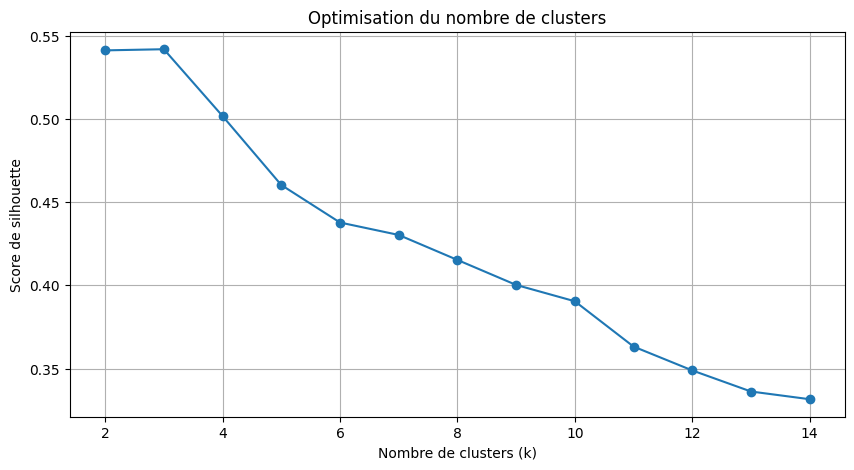

✅ Meilleur nombre de clusters : 3


In [47]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    scores.append(score)

# Visualisation des scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, scores, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score de silhouette")
plt.title("Optimisation du nombre de clusters")
plt.grid(True)
plt.show()

# Meilleur k
best_k = K_range[np.argmax(scores)]
print("✅ Meilleur nombre de clusters :", best_k)


 Interprétation : Le meilleur score est obtenu pour k = 3. Cela signifie que diviser les données en 3 groupes est le plus cohérent avec la structure des données.

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


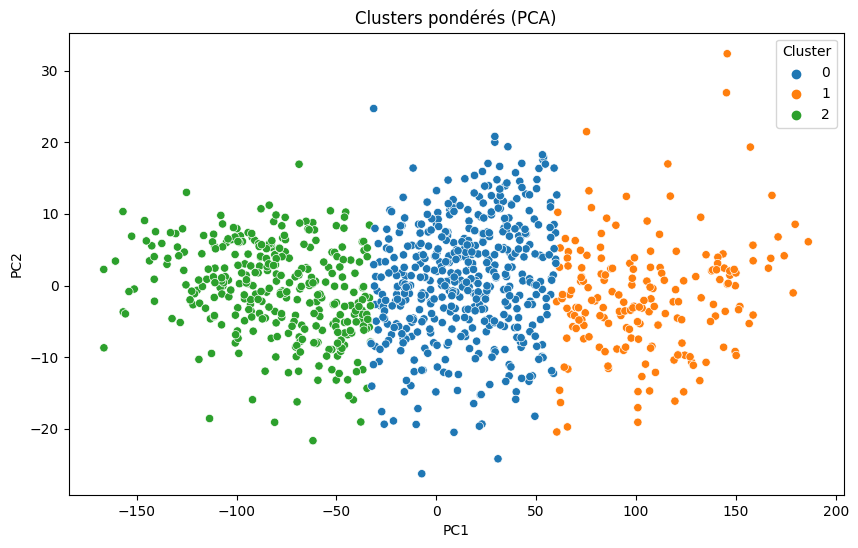

In [48]:
importance_df['norm_importance'] = importance_df['importance'] / importance_df['importance'].sum()

# Pondérer les features dans X
X_weighted = X.copy()
for feature in importance_df['feature']:
    if feature in X_weighted.columns:
        weight = importance_df.loc[importance_df['feature'] == feature, 'norm_importance'].values[0]
        X_weighted[feature] *= weight

# Recalcul du clustering avec pondération
kmeans_weighted = KMeans(n_clusters=best_k, random_state=42)
df['cluster_weighted'] = kmeans_weighted.fit_predict(X_weighted)

# Visualisation après pondération (optionnel)
X_pca_weighted = PCA(n_components=2).fit_transform(X_weighted)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca_weighted[:, 0], y=X_pca_weighted[:, 1], hue=df['cluster_weighted'], palette='tab10')
plt.title('Clusters pondérés (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()


Pondération des features selon leur importance
Cela permet au clustering (KMeans) de se concentrer davantage sur les caractéristiques qui comptent vraiment pour différencier les genres musicaux.

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

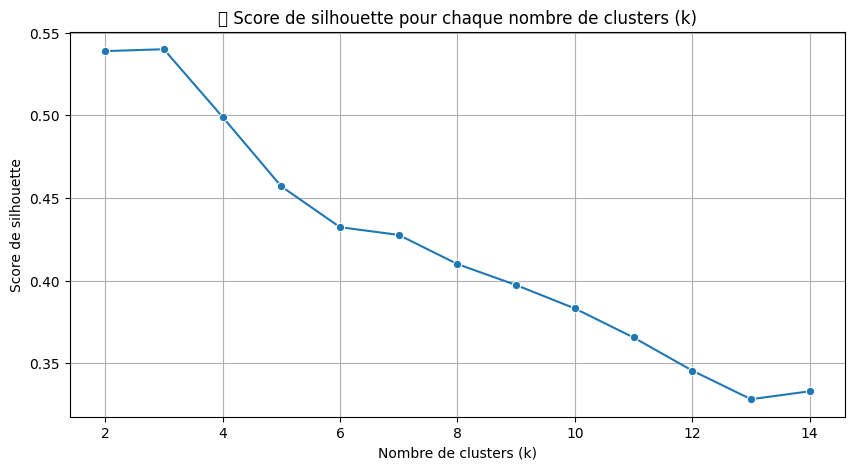

✅ Meilleur nombre de clusters selon le score de silhouette : 3


In [57]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_weighted)
    score = silhouette_score(X_weighted, labels)
    scores.append(score)

# Affichage
plt.figure(figsize=(10, 5))
sns.lineplot(x=list(K_range), y=scores, marker='o')
plt.title('🎯 Score de silhouette pour chaque nombre de clusters (k)')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette')
plt.grid(True)
plt.show()

# Meilleur k
best_k = K_range[scores.index(max(scores))]
print(f"✅ Meilleur nombre de clusters selon le score de silhouette : {best_k}")


Réévaluer la NDCG, F1, etc. apres Pondération 



In [52]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_recommendation(df, top_k=5):
    y_true, y_pred = [], []

    for idx, row in df.iterrows():
        query_vector = X_weighted.iloc[idx]
        query_label = row['label']
        
        # Similarité cosinus avec toutes les autres
        similarities = cosine_similarity([query_vector], X_weighted)[0]
        indices = similarities.argsort()[::-1][1:top_k+1]
        
        predicted_labels = df.iloc[indices]['label'].tolist()
        true_labels = [query_label] * top_k

        y_true.extend(true_labels)
        y_pred.extend(predicted_labels)

    try:
        print("✅ Évaluation globale sur les recommandations :")
        print("Précision :", precision_score(y_true, y_pred, average='macro'))
        print("Rappel :", recall_score(y_true, y_pred, average='macro'))
        print("F1 Score :", f1_score(y_true, y_pred, average='macro'))
    except Exception as e:
        print("❌ Erreur pendant l’évaluation :", e)


In [53]:
evaluate_recommendation(df)


✅ Évaluation globale sur les recommandations :
Précision : 0.3456347946942303
Rappel : 0.34384242424242417
F1 Score : 0.3445688484011028


In [54]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ndcg_score

# Encodage des labels
le = LabelEncoder()
encoded_labels = le.fit_transform(df['label'])

# Générer des scores de similarité pour chaque sample
ndcg_scores = []
for i in range(len(df)):
    query_vector = X_weighted.iloc[i]
    true_label = encoded_labels[i]

    sims = cosine_similarity([query_vector], X_weighted)[0]
    indices = sims.argsort()[::-1][1:11]

    true_relevance = [1 if encoded_labels[j] == true_label else 0 for j in indices]
    predicted_scores = sims[indices]

    ndcg = ndcg_score([true_relevance], [predicted_scores])
    ndcg_scores.append(ndcg)

print(f"✅ NDCG moyen sur les recommandations : {np.mean(ndcg_scores):.4f}")


✅ NDCG moyen sur les recommandations : 0.6036


In [56]:
compute_diversity(df)

✅ Diversité moyenne : 0.0002
